<a href="https://colab.research.google.com/github/mmikite/MI_hzxa37/blob/main/11_genAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Szuperhős nevek generálás

---
Egy névgenerátort hozzunk létre, amely egy megadott adatbázis alapján  egy üres karakterlánc, egy előtag vagy egy utótag megadásával mintát követve hoz létre szöveget.
az adatbázis lehet egy szótár, több különböző nyelv szótára, cégnevek listája, mondatok, valami vegyes stb. Ez rajtunk múlik, és az eredmény is ettől függ; az egyszerűség kedvéért egy szupehősök neveit használjuk.


[Superhero Names Dataset](https://github.com/am1tyadav/superhero)

## 1. lépés

1. Adatok beolvasása
2. Tokenizer készítése
3. karaktert indexxé, iletve az indexekel karakterré alakító szótárat hozunk létre.

In [ ]:
!git clone https://github.com/am1tyadav/superhero

Cloning into 'superhero'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 8 (delta 0), reused 4 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (8/8), 47.08 KiB | 9.42 MiB/s, done.


In [ ]:
!ls . && ls superhero

sample_data  superhero
LICENSE  README.md  superheroes.txt


In [ ]:
with open('superhero/superheroes.txt', 'r') as f:
  data = f.read()

In [ ]:
print(data[:200])

jumpa	
doctor fate	
starlight	
isildur	
lasher	
varvara	
the target	
axel	
battra	
changeling	
pyrrha	
the rhino	
major glory	
drago	
king vegeta	
phoebus apollo	
warpath	
the lost sapphire	
durok the


A névgeneráláshoz mélytanuló neurális hálózatot használunk, amit <a href="https://keras.io/">Keras</a> API könyvtárat használunk, amit <a href="https://www.tensorflow.org/">Tesorflow</a> segítségével fogunk futtatni.

In [ ]:
import tensorflow as tf
tf.__version__

'2.18.0'

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~',
    split='\n',
)

In [ ]:
tokenizer.fit_on_texts(data)

Listát készítünk minden egyes karakterről, amely az adatokban megtalálható.

In [ ]:
char_to_index = tokenizer.word_index
char_to_index

{'\t': 1,
 'a': 2,
 'e': 3,
 'r': 4,
 'o': 5,
 'n': 6,
 'i': 7,
 ' ': 8,
 't': 9,
 's': 10,
 'l': 11,
 'm': 12,
 'h': 13,
 'd': 14,
 'c': 15,
 'u': 16,
 'g': 17,
 'k': 18,
 'b': 19,
 'p': 20,
 'y': 21,
 'w': 22,
 'f': 23,
 'v': 24,
 'j': 25,
 'z': 26,
 'x': 27,
 'q': 28}

In [ ]:
index_to_char = dict((v, k) for k, v in char_to_index.items())
index_to_char

{1: '\t',
 2: 'a',
 3: 'e',
 4: 'r',
 5: 'o',
 6: 'n',
 7: 'i',
 8: ' ',
 9: 't',
 10: 's',
 11: 'l',
 12: 'm',
 13: 'h',
 14: 'd',
 15: 'c',
 16: 'u',
 17: 'g',
 18: 'k',
 19: 'b',
 20: 'p',
 21: 'y',
 22: 'w',
 23: 'f',
 24: 'v',
 25: 'j',
 26: 'z',
 27: 'x',
 28: 'q'}

## 2. lépés

1. A nevek és szekvenciák konvertálása

In [ ]:
names = data.split('\n')
names[:10]

['jumpa\t',
 'doctor fate\t',
 'starlight\t',
 'isildur\t',
 'lasher\t',
 'varvara\t',
 'the target\t',
 'axel\t',
 'battra\t',
 'changeling\t']

In [ ]:
tokenizer.texts_to_sequences(names[0])

[[25], [16], [12], [20], [2], [1]]

In [ ]:
t_to_sq = lambda name:[tokenizer.texts_to_sequences(c)[0][0] for c in name]

In [ ]:
sq_to_t = lambda s :''.join([index_to_char[i] for i in s if i!=0])

In [ ]:
t_to_sq(names[0]), sq_to_t(t_to_sq(names[0]))

([25, 16, 12, 20, 2, 1], 'jumpa\t')

In [ ]:
list(map(t_to_sq, ['holaaa','lalalaaa']))

[[13, 5, 11, 2, 2, 2], [11, 2, 11, 2, 11, 2, 2, 2]]

In [ ]:
list(map(sq_to_t, [[13, 5, 11, 2, 2, 2], [11, 2, 11, 2, 11, 2, 2, 2]]))

['holaaa', 'lalalaaa']

## 3. lépés

1. Szekvenciák létrehozása
2. Az összes szekvencia egy hosszra hozása

A szöveget maxlen karakterekből álló, félig redundáns sorozatokban vágjuk, hozzáadva egy nullákból álló előtétet. Ha például a hello szó maximális hossza 20, akkor a következő szekvenciát fogjuk létrehozni: 0000000000000000hello.

*Miért rögzítjük a szavak méretét?*

Kiderült, hogy ha a TensorFlow-ban egy fix méretet adunk át egy LSTM-nek, akkor a képzés sebessége gyorsabb, mert fix alakú tenzorokat hoz létre, így sok műveletet érhetünk el egyetlen mátrixműveletben.

*Miért adtam hozzá előtétet és nem utólagos nullákat?*

Az LSTM-ek egy adatsorozat alapján tanulnak, és megpróbálnak kapcsolatot találni a múlttal, a bemenethez fehér zajt, azaz LSTM-előtétet adni a legjobb megoldás.

In [ ]:
sequences = []

for l in list(map(t_to_sq, names)):
  for i in range(2, len(l)+1):
    sequences += [l[:i]]

sequences

[[25, 16],
 [25, 16, 12],
 [25, 16, 12, 20],
 [25, 16, 12, 20, 2],
 [25, 16, 12, 20, 2, 1],
 [14, 5],
 [14, 5, 15],
 [14, 5, 15, 9],
 [14, 5, 15, 9, 5],
 [14, 5, 15, 9, 5, 4],
 [14, 5, 15, 9, 5, 4, 8],
 [14, 5, 15, 9, 5, 4, 8, 23],
 [14, 5, 15, 9, 5, 4, 8, 23, 2],
 [14, 5, 15, 9, 5, 4, 8, 23, 2, 9],
 [14, 5, 15, 9, 5, 4, 8, 23, 2, 9, 3],
 [14, 5, 15, 9, 5, 4, 8, 23, 2, 9, 3, 1],
 [10, 9],
 [10, 9, 2],
 [10, 9, 2, 4],
 [10, 9, 2, 4, 11],
 [10, 9, 2, 4, 11, 7],
 [10, 9, 2, 4, 11, 7, 17],
 [10, 9, 2, 4, 11, 7, 17, 13],
 [10, 9, 2, 4, 11, 7, 17, 13, 9],
 [10, 9, 2, 4, 11, 7, 17, 13, 9, 1],
 [7, 10],
 [7, 10, 7],
 [7, 10, 7, 11],
 [7, 10, 7, 11, 14],
 [7, 10, 7, 11, 14, 16],
 [7, 10, 7, 11, 14, 16, 4],
 [7, 10, 7, 11, 14, 16, 4, 1],
 [11, 2],
 [11, 2, 10],
 [11, 2, 10, 13],
 [11, 2, 10, 13, 3],
 [11, 2, 10, 13, 3, 4],
 [11, 2, 10, 13, 3, 4, 1],
 [24, 2],
 [24, 2, 4],
 [24, 2, 4, 24],
 [24, 2, 4, 24, 2],
 [24, 2, 4, 24, 2, 4],
 [24, 2, 4, 24, 2, 4, 2],
 [24, 2, 4, 24, 2, 4, 2, 1],
 [9, 13],


A szöveget maxlen (nálunk 33) karakterekből álló, félig redundáns szekvenciákra vágjuk, esetlegesen a rövidebb elemeket nullákkal töltjük fel.

In [ ]:
max_len = max([len(x) for x in sequences])
max_len

33

In [ ]:
padding_sequences = tf.keras.preprocessing.sequence.pad_sequences(
    sequences,
    padding='pre',
    maxlen=max_len
)
padding_sequences

array([[ 0,  0,  0, ...,  0, 25, 16],
       [ 0,  0,  0, ..., 25, 16, 12],
       [ 0,  0,  0, ..., 16, 12, 20],
       ...,
       [ 0,  0,  0, ..., 11,  5, 20],
       [ 0,  0,  0, ...,  5, 20, 10],
       [ 0,  0,  0, ..., 20, 10,  1]], dtype=int32)

In [ ]:
padding_sequences.shape

(88279, 33)

## 4. lépés: Gyakorló és validáló halmazok létrehozása

1. Gyakorló és validáló halmazok létrehozása

In [ ]:
padding_sequences[:,-1]
padding_sequences[:, :-1]

array([[ 0,  0,  0, ...,  0,  0, 25],
       [ 0,  0,  0, ...,  0, 25, 16],
       [ 0,  0,  0, ..., 25, 16, 12],
       ...,
       [ 0,  0,  0, ..., 15, 11,  5],
       [ 0,  0,  0, ..., 11,  5, 20],
       [ 0,  0,  0, ...,  5, 20, 10]], dtype=int32)

In [ ]:
x, y = padding_sequences[:, :-1], padding_sequences[:, -1]
x.shape, y.shape

((88279, 32), (88279,))

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
x_train.shape, x_test.shape

((70623, 32), (17656, 32))

In [ ]:
num_chars = len(list(char_to_index.keys()) + ['0']) # also include padding char
num_chars

29

## 5. lépés a modell elkészítése

Létrehozok egy LSTM modellt egy további Dense réteggel, amelynek aktiválási függvénye softmax.
Veszteségfüggvényként a categorical_crossentropy-t használjuk, mert ezt többnyire kategorikus kimenettel rendelkező ilyen jellegű problémáknál használják.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPool1D, Dense, LSTM, Bidirectional

feature_vector_dim = 8

model = Sequential([
    Embedding(input_dim=num_chars, output_dim=8, input_length=max_len-1),
    Conv1D(64, 5, strides=1, activation='tanh', padding='causal'),
    MaxPool1D(2),
    LSTM(32),
    Dense(num_chars, activation='softmax')
])

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#tf.keras.utils.plot_model(model, show_shapes=True, dpi=76)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPool1D, Dense, LSTM, Bidirectional

feature_vector_dim = 8

bidir_model = Sequential([
    Embedding(input_dim=num_chars, output_dim=8, input_length=max_len-1),
    Conv1D(64, 5, strides=1, activation='tanh', padding='causal'),
    MaxPool1D(2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    Dense(num_chars, activation='softmax')
])

bidir_model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

bidir_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#tf.keras.utils.plot_model(bidir_model, show_shapes=True, dpi=76)

## 6. lépés: A modell betanítása

In [ ]:
history1 = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=50,
    verbose=2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
    ]
)

Epoch 1/50
2207/2207 - 20s - 9ms/step - accuracy: 0.1933 - loss: 2.7331 - val_accuracy: 0.2204 - val_loss: 2.5958
Epoch 2/50
2207/2207 - 17s - 8ms/step - accuracy: 0.2341 - loss: 2.5442 - val_accuracy: 0.2401 - val_loss: 2.5215
Epoch 3/50
2207/2207 - 13s - 6ms/step - accuracy: 0.2537 - loss: 2.4669 - val_accuracy: 0.2569 - val_loss: 2.4508
Epoch 4/50
2207/2207 - 14s - 6ms/step - accuracy: 0.2692 - loss: 2.4142 - val_accuracy: 0.2653 - val_loss: 2.4165
Epoch 5/50
2207/2207 - 20s - 9ms/step - accuracy: 0.2780 - loss: 2.3769 - val_accuracy: 0.2762 - val_loss: 2.3817
Epoch 6/50
2207/2207 - 20s - 9ms/step - accuracy: 0.2878 - loss: 2.3454 - val_accuracy: 0.2778 - val_loss: 2.3617
Epoch 7/50
2207/2207 - 13s - 6ms/step - accuracy: 0.2967 - loss: 2.3181 - val_accuracy: 0.2933 - val_loss: 2.3409
Epoch 8/50
2207/2207 - 13s - 6ms/step - accuracy: 0.3065 - loss: 2.2933 - val_accuracy: 0.2946 - val_loss: 2.3150
Epoch 9/50
2207/2207 - 21s - 10ms/step - accuracy: 0.3126 - loss: 2.2701 - val_accuracy:

In [ ]:
# took too long as GPU was not available :(

# history2 = bidir_model.fit(
#     x_train,
#     y_train,
#     validation_data=(x_test, y_test),
#     epochs=50,
#     verbose=2,
#     callbacks=[
#         tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
#     ]
# )

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

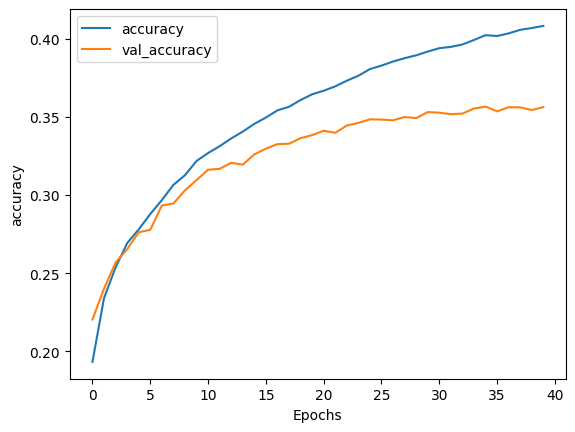

In [ ]:
plot_graphs(history1, 'accuracy')

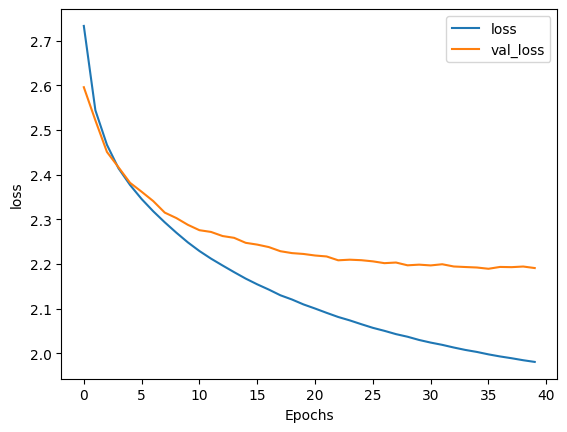

In [ ]:
plot_graphs(history1, 'loss')

## 7. lépés: Névgenerálás

In [ ]:
def generate_names(seed):
  for i in range(0, 40):
    seq = t_to_sq(seed)
    padded = tf.keras.preprocessing.sequence.pad_sequences(
        [seq],
        padding='pre',
        maxlen=max_len-1,
        truncating='pre'
    )
    pred = tf.argmax(model.predict(padded, verbose=False)[0]).numpy()
    pred_char = index_to_char[pred]
    seed += pred_char
    if pred_char == '\t':
      break
  return seed

In [ ]:
print(generate_names('ab'))
print(generate_names('magi'))
print(generate_names('her'))
print(generate_names('po'))
print(generate_names('sil'))

aberging	
magin the shank	
herange man	
porner shanes	
silver shane	
